<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Qtensor-vs-other-simulators:-speed" data-toc-modified-id="Qtensor-vs-other-simulators:-speed-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Qtensor vs other simulators: speed</a></span><ul class="toc-item"><li><span><a href="#Generate-data" data-toc-modified-id="Generate-data-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Generate data</a></span></li><li><span><a href="#Generate-data" data-toc-modified-id="Generate-data-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Generate data</a></span></li><li><span><a href="#Read-data" data-toc-modified-id="Read-data-1.3"><span class="toc-item-num">1.3&nbsp;&nbsp;</span>Read data</a></span></li><li><span><a href="#Plot-comparisons" data-toc-modified-id="Plot-comparisons-1.4"><span class="toc-item-num">1.4&nbsp;&nbsp;</span>Plot comparisons</a></span></li><li><span><a href="#CLI" data-toc-modified-id="CLI-1.5"><span class="toc-item-num">1.5&nbsp;&nbsp;</span>CLI</a></span></li></ul></li></ul></div>

# Qtensor vs other simulators: speed

The functions from this notebook are exported and invoken on a remote server.

The data that is generated is transferred back to local machine and plotted here as well

## Generate data

In [1]:
#export
import numpy as np
import qtensor as qt
from qtensor.tests.qiskit_qaoa_energy import simulate_qiskit_amps
from qtensor.tests.qaoa_quimb import simulate_one_parallel as simulate_quimb_energy
from qtensor.tests.acqdp_qaoa import single_qaoa_query as simulate_acqdp_energy
import matplotlib.pyplot as plt
import time

from cartesian_explorer import Explorer, caches

/home/danlkv/.local/bin/lib/python3.8/site-packages/numba-0.52.0rc2-py3.8-linux-x86_64.egg/numba/np/ufunc/parallel.py:363: NumbaWarning: The TBB threading layer requires TBB version 2019.5 or later i.e., TBB_INTERFACE_VERSION >= 11005. Found TBB_INTERFACE_VERSION = 10000. The TBB threading layer is disabled.
  warnings.warn(problem)


In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
#export

cache = caches.JobLibCache('../../caex_cache/skylake_speed_comparison')
ex = Explorer(cache=cache)

In [4]:
#export    
@ex.provider
def graph(N, d=3, graph_type='random', seed=10):
    return qt.toolbox.random_graph(nodes=N, type=graph_type, degree=d, seed=seed)

In [5]:
#export
@ex.provider
def qiskit_time(graph, p):
    gamma, beta = [.1]*p, [.3]*p
    start = time.time()
    try:
        _ = simulate_qiskit_amps(graph, gamma, beta)
    except Exception as e:
        print('Exception:', e)
        return None
    end = time.time()
    return end - start

In [6]:
qis_time = ex.get_variable('qiskit_time', N=10, p=2)
print(qis_time)

INFO:qiskit.transpiler.runningpassmanager:Pass: Unroller - 10.59914 (ms)
INFO:qiskit.transpiler.runningpassmanager:Pass: RemoveResetInZeroState - 0.10800 (ms)
INFO:qiskit.transpiler.runningpassmanager:Pass: Unroller - 10.79297 (ms)
INFO:qiskit.transpiler.runningpassmanager:Pass: RemoveResetInZeroState - 0.09942 (ms)
INFO:qiskit.transpiler.runningpassmanager:Pass: Depth - 3.89051 (ms)
INFO:qiskit.transpiler.runningpassmanager:Pass: FixedPoint - 0.00906 (ms)
INFO:qiskit.transpiler.runningpassmanager:Pass: Optimize1qGates - 4.44078 (ms)
INFO:qiskit.transpiler.runningpassmanager:Pass: CXCancellation - 1.74785 (ms)
INFO:qiskit.transpiler.runningpassmanager:Pass: Depth - 3.02529 (ms)
INFO:qiskit.transpiler.runningpassmanager:Pass: FixedPoint - 0.00787 (ms)
INFO:qiskit.transpiler.runningpassmanager:Pass: Optimize1qGates - 2.69365 (ms)
INFO:qiskit.transpiler.runningpassmanager:Pass: CXCancellation - 1.79529 (ms)
INFO:qiskit.transpiler.runningpassmanager:Pass: Depth - 3.09634 (ms)
INFO:qiskit.t

0.14782190322875977


In [7]:
#export
@ex.provider
def quimb_time(graph, p,
               n_processes=2,
               qmb_optimizer_time=0.3,
               qmb_ordering_algo='uniform'
              ):
    start = time.time()
    try:
        _ = simulate_quimb_energy(graph, p,
                                  n_processes=n_processes,
                                  optimizer_time=qmb_optimizer_time,
                                  ordering_algo=qmb_ordering_algo
                                 )
    except Exception as e:
        print('Exception:', e)
        return None
    end = time.time()
    return end - start

In [8]:
qis_time = ex.get_variable('quimb_time', N=10, p=2)
print(qis_time)


3.3847742080688477


In [24]:
@ex.provider
def acqdp_time(graph, p, acqdp_orderer='oe'):
    start = time.time()
    try:
        _  = simulate_acqdp_energy(graph, p, ordering_algo=acqdp_orderer)
    except Exception as e:
        print('Exception', e)
        return None
    end = time.time()
    return end - start

In [32]:
_time = ex.get_variable('acqdp_time', N=10, p=2, acqdp_orderer='default')
_time2 = ex.get_variable('acqdp_time', N=10, p=2, acqdp_orderer='oe')
print(_time, _time2)

0.42075324058532715 0.39375805854797363


In [11]:
#export
@ex.provider
def qtensor_time(graph, p,
               n_processes=2,
               qtn_ordering_algo='greedy'
              ):
    gamma, beta = [.1]*p, [.3]*p
    opt = qt.toolbox.get_ordering_algo(qtn_ordering_algo)
    sim = qt.QAOAQtreeSimulator(qt.DefaultQAOAComposer, optimizer=opt)
    start = time.time()
    try:
        _ = sim.energy_expectation_parallel(graph, gamma, beta, n_processes=n_processes)
    except Exception as e:
        print('Exception:', e)
        return None
    end = time.time()
    return end - start

In [12]:
qis_time = ex.get_variable('qtensor_time', N=10, p=2)
print(qis_time)


0.1412370204925537


## Generate data

In [33]:
#export
def gen_time_data(Ns, ps, **kwargs):
    xar = ex.get_variables_xarray(
        ('qtensor_time', 'quimb_time', 'acqdp_time'),
        p=ps,
        N=Ns,
        **kwargs,
    )
    return xar

In [34]:
Ns = 2*(.5*np.pi**(np.arange(0, 12)/2)).astype(np.int) + 10
Ns = Ns[1:10]

ps = [2, 3, 4]
xar = gen_time_data(Ns, ps, n_processes=[56],
                    qtn_ordering_algo=['rgreedy_0.02_10'], quimb_optimizer_time=[1.])
xar

 28%|██▊       | 5/18 [00:00<00:00, 41.54it/s]

Preprocessing for energy query...


 24%|██▍       | 5/21 [00:00<00:00, 41.68it/s]

Preprocessing time for queries: 0.44043636322021484
E([0.5058283240675293, 0.022827020409951833, 1.8051942486396853, -1.9834976870572765]) = (-5.340701798721897+2.7515314044577876e-16j)
Preprocessing for energy query...


 15%|█▍        | 4/27 [00:00<00:00, 38.18it/s]

Preprocessing time for queries: 0.49400949478149414
E([-0.596513656194049, 1.469122082263929, 1.6005752312852624, 0.3290412609300976]) = (4.158401070372128-1.3492135212767568e-16j)
Preprocessing for energy query...


 13%|█▎        | 5/39 [00:00<00:00, 40.58it/s]

Preprocessing time for queries: 0.6953113079071045
E([0.6471005365871851, -0.1037199693587922, 0.33247415796347135, 1.3186034148124948]) = (2.196552333549736+2.892651396191326e-16j)
Preprocessing for energy query...


  7%|▋         | 4/60 [00:00<00:01, 39.44it/s]

Preprocessing time for queries: 1.2570223808288574
E([0.5954972065774632, -1.4779648006526986, 0.7142277633951183, -0.0827375736597647]) = (0.5632505443282159+1.6291841016119996e-16j)
Preprocessing for energy query...


  0%|          | 0/96 [00:00<?, ?it/s]

Preprocessing time for queries: 1.529698133468628
E([-1.9115943938120021, 0.7550867545642066, 0.5193598620359269, -0.3676907119542829]) = (23.23987080480584+1.20030943753612e-15j)
Preprocessing for energy query...


  0%|          | 0/159 [00:00<?, ?it/s]

Preprocessing time for queries: 2.4214870929718018
E([1.4151580667811763, 0.38635147196600095, 0.27324376662569827, -0.8817697189499363]) = (-22.04748131131578-1.5742615544489524e-15j)
Preprocessing for energy query...


 50%|████▉     | 79/159 [00:00<00:00, 782.40it/s]

Preprocessing time for queries: 4.464344024658203


  1%|▏         | 4/273 [00:00<00:07, 37.40it/s]

E([-0.1463005589933148, -0.10859458255369098, 0.3282731467450137, -0.566152727466784]) = (-10.125901473240141-1.6506907273189342e-15j)
Preprocessing for energy query...


 32%|███▏      | 87/273 [00:00<00:00, 862.81it/s]

Preprocessing time for queries: 7.782786846160889


 13%|█▎        | 2/15 [00:00<00:00, 19.27it/s]

E([2.37430554472039, 1.3831862278067404, 1.5045516843500524, 0.5999604663790018]) = (5.884915098331257+3.055684125401232e-15j)
Preprocessing for energy query...


  0%|          | 0/18 [00:00<?, ?it/s]

Preprocessing time for queries: 0.7859408855438232
E([1.0469926525803108, -0.08699773499304764, 1.8544587704238122, -0.7709121882580879, -2.2503507869480703, -0.41226490495142987]) = (-0.1771898185807151-1.446011511984235e-17j)
Preprocessing for energy query...


 44%|████▍     | 8/18 [00:00<00:00, 61.84it/s]

Preprocessing time for queries: 0.9678480625152588


 10%|▉         | 2/21 [00:00<00:01, 17.41it/s]

E([0.9699907654673805, -0.19038655672859833, -0.011120359376754761, -0.47876347251487744, -0.81942379719016, 0.3742113185360609]) = (3.911256819961514+1.5929944010824742e-16j)
Preprocessing for energy query...


 52%|█████▏    | 11/21 [00:00<00:00, 107.68it/s]

Preprocessing time for queries: 1.1887238025665283


  0%|          | 0/27 [00:00<?, ?it/s]

E([-0.8689961918936976, 0.2678165013043721, -0.5775606578285121, 0.15784907413764518, 0.5456551054491234, -0.20348655998846615]) = (-8.170395098739528-3.7529045935301104e-16j)
Preprocessing for energy query...


 15%|█▍        | 4/27 [00:00<00:00, 39.78it/s]

Preprocessing time for queries: 2.0663671493530273


  5%|▌         | 2/39 [00:00<00:02, 17.56it/s]

E([-0.34219606687716, 0.30667282904174403, 0.38149641768294273, 0.2305383596265898, -1.04890673864069, 0.8806735197341738]) = (-5.068193665778186+2.969495946689316e-16j)
Preprocessing for energy query...


 38%|███▊      | 15/39 [00:00<00:00, 138.70it/s]

Preprocessing time for queries: 2.6618616580963135


  0%|          | 0/60 [00:00<?, ?it/s]

E([-0.24584623132802413, 0.34504272269902175, 1.9750659992015127, 0.10517037405981786, -0.24456958288103606, 0.17783701847918723]) = (11.849610225977566-2.0479941847533106e-16j)
Preprocessing for energy query...


  0%|          | 0/60 [00:00<?, ?it/s]

Preprocessing time for queries: 4.515668630599976


  2%|▏         | 2/96 [00:00<00:06, 14.01it/s]

E([0.8952901613941278, 0.5199276173511904, 0.4841408452973527, -1.3418303804085225, 0.6023404739953043, 0.7056603121147438]) = (-9.051564561702154+6.936354555648033e-17j)
Preprocessing for energy query...


 33%|███▎      | 32/96 [00:00<00:00, 315.81it/s]

Preprocessing time for queries: 7.330126523971558


  1%|▏         | 2/159 [00:00<00:11, 14.09it/s]

E([-0.5863411133115447, -0.48926332205789075, -1.1779677884555082, 1.538248574925038, -0.26642781004984456, -1.258749289635831]) = (17.013325577500378-3.1463182718264435e-15j)
Preprocessing for energy query...


 18%|█▊        | 29/159 [00:00<00:00, 236.63it/s]

Preprocessing time for queries: 11.874065637588501


  1%|          | 2/273 [00:00<00:19, 13.84it/s]

E([-1.6950274860062184, 0.7062732698640785, -1.3025627422783006, 0.0787986353818606, -0.18882899933065236, -0.4817239095352436]) = (-52.90845052762207-2.312320771815273e-15j)
Preprocessing for energy query...


 11%|█         | 30/273 [00:00<00:00, 297.39it/s]

Preprocessing time for queries: 21.374621868133545


 13%|█▎        | 2/15 [00:00<00:01, 12.26it/s]

E([0.15973176664223526, 1.352766531499814, 0.46408746975452525, -1.104057081193582, -0.7716374330640989, -2.4171551626701433]) = (-79.03335572763902+7.789746514334235e-16j)
Preprocessing for energy query...


 27%|██▋       | 4/15 [00:00<00:00, 20.53it/s]

Preprocessing time for queries: 1.4822347164154053


 11%|█         | 2/18 [00:00<00:01, 11.89it/s]

E([-0.8849615223598889, -0.19163412851502018, -0.8427473384861354, -0.2863646294863693, 0.7214501774733951, -1.2397358344512361, -0.418723250782041, 0.16391974082138983]) = (0.95047819927439+4.136431461280061e-17j)
Preprocessing for energy query...


 17%|█▋        | 3/18 [00:00<00:00, 23.98it/s]

Preprocessing time for queries: 1.7760159969329834


  5%|▍         | 1/21 [00:00<00:02,  9.62it/s]

E([-0.3773178377538547, -0.9172477998110362, -2.0798697579734076, -1.2401017920281656, 0.143324504880441, -0.9750890565166455, -0.7946798078690085, 1.8567210244860768]) = (-0.5944054288117275-1.6185499895458392e-16j)
Preprocessing for energy query...


  0%|          | 0/21 [00:00<?, ?it/s]

Preprocessing time for queries: 2.3192715644836426


  0%|          | 0/27 [00:00<?, ?it/s]

E([-1.9049748962917255, 1.0307254657263336, 1.0818430967236732, -1.4000451457882472, -0.7630286972279878, 0.42146788613421177, 0.7029706973196351, 0.3802102486466844]) = (1.3725891877205865-1.8173328382492857e-16j)
Preprocessing for energy query...


  3%|▎         | 1/39 [00:00<00:04,  8.26it/s]

Exception The contraction cannot be done on the current machine. Try finding a more space-efficient order, or slice the order to fit in the memory.
Preprocessing for energy query...


  0%|          | 0/39 [00:00<?, ?it/s]

Preprocessing time for queries: 5.348571062088013


  2%|▏         | 1/60 [00:00<00:09,  6.45it/s]

Internal error while evaluating `ContractExpression`. Note that few checks are performed - the number and rank of the array arguments must match the original expression. The internal error was: '('too many subscripts in einsum',)'
('c', [[(0, array([[ 0.97496303+0.j        , -0.        -0.22236703j],
       [-0.        -0.22236703j,  0.97496303+0.j        ]]))], [(0, array([[0.97496303+0.j        , 0.        +0.22236703j],
       [0.        +0.22236703j, 0.97496303+0.j        ]]))], [(0, array([[ 0.97496303+0.j        , -0.        -0.22236703j],
       [-0.        -0.22236703j,  0.97496303+0.j        ]]))], [(0, array([[0.97496303+0.j        , 0.        +0.22236703j],
       [0.        +0.22236703j, 0.97496303+0.j        ]]))], [(0, array([[0.39428543-0.91898803j, 0.39428543+0.91898803j],
       [0.39428543+0.91898803j, 0.39428543-0.91898803j]]))], [(0, array([[0.39428543+0.91898803j, 0.39428543-0.91898803j],
       [0.39428543-0.91898803j, 0.39428543+0.91898803j]]))], [(0, array([[0.3

  0%|          | 0/96 [00:00<?, ?it/s]

Exception The contraction cannot be done on the current machine. Try finding a more space-efficient order, or slice the order to fit in the memory.
Preprocessing for energy query...


  1%|          | 1/96 [00:00<00:14,  6.47it/s]

Preprocessing time for queries: 19.009272813796997


  0%|          | 0/159 [00:00<?, ?it/s]

E([-0.7146339364779918, -1.6578932707530583, -1.3890503883645082, -0.9163866649717195, 1.16933144309079, -0.6333905421104279, 0.5213054549657308, 2.6732400763258357]) = (13.420008694754705+5.899105865358965e-17j)
Preprocessing for energy query...


  1%|          | 1/159 [00:00<00:17,  9.11it/s]

Preprocessing time for queries: 28.800888776779175


100%|██████████| 159/159 [02:58<00:00,  1.12s/it]


E([-0.28062117368604056, -1.0669965156011905, -0.9169196414498711, 0.8872064562164675, -0.7322596766037343, -1.4621240467020595, -0.8054012694149304, -0.7648818842510148]) = (-0.27120877103109403+1.670393669946225e-17j)


  0%|          | 0/273 [00:00<?, ?it/s]


Preprocessing for energy query...


  0%|          | 0/273 [00:00<?, ?it/s]

Preprocessing time for queries: 52.85286283493042


100%|██████████| 273/273 [00:48<00:00,  5.68it/s]


E([-0.7539750057597379, -0.6541611390912333, 0.6077986314106315, -0.42415440100698804, -0.6394391855859894, 0.34413015440606554, -1.8033342540970552, -0.8745429663578702]) = (0.7783353745074225+1.1359742432680727e-15j)




_dimcount 3


<xarray.DataArray (varname: 3, p: 3, N: 9)>
array([[[0.4141528606414795, 0.4294466972351074, 0.44785046577453613,
         0.45202112197875977, 0.47057676315307617, 0.49799561500549316,
         0.5493118762969971, 0.6811766624450684, 0.8248779773712158],
        [0.4631826877593994, 0.5265576839447021, 0.5384366512298584,
         0.5805747509002686, 0.6007285118103027, 0.7623679637908936,
         0.8984177112579346, 1.326380968093872, 1.780289649963379],
        [0.6110918521881104, 0.6834065914154053, 1.0001606941223145,
         6.728485822677612, 1.417675256729126, 4.814037084579468,
         2.9536478519439697, 3.5474908351898193, 4.832934379577637]],

       [[0.853773832321167, 0.8594746589660645, 0.8932580947875977,
         1.00437593460083, 1.407236099243164, 1.467494249343872,
         2.436371326446533, 5.325958490371704, 12.905457735061646],
        [0.872220516204834, 0.9501066207885742, 0.9568071365356445,
         1.4102864265441895, 1.8343234062194824, 1.6941251754760742,
         3.292548179626465, 6.8518359661102295, 19.521596431732178],
        [1.097529649734497, 1.198817253112793, 2.0999228954315186, None,
         32.586326122283936, None, None, 24.776636362075806,
         31.506675481796265]],

       [[0.39375805854797363, 0.46189045906066895, 0.5184328556060791,
         0.7293896675109863, 1.3053584098815918, 1.605071783065796,
         2.5494463443756104, 4.692929267883301, 8.133355855941772],
        [0.932262659072876, 1.211482048034668, 1.4285502433776855,
         3.0575523376464844, 3.390338659286499, 5.585901737213135,
         7.661188364028931, 12.540937423706055, 22.393937826156616],
        [1.91526198387146, 8.41214656829834, 110.15074467658997, None,
         None, None, 869.7970194816589, 207.59811878204346,
         101.07938480377197]]], dtype=object)
Coordinates:
  * varname  (varname) <U12 'qtensor_time' 'quimb_time' 'acqdp_time'
  * p        (p) int64 2 3 4
  * N        (N) int64 10 12 14 18 26 40 64 106 182

## Read data

In [66]:
import xarray
xar = xarray.load_dataarray('../../../second_try.nc')

## Plot comparisons


Text(0.5, 0.98, 'Time for single energy query on a single Skylake node')

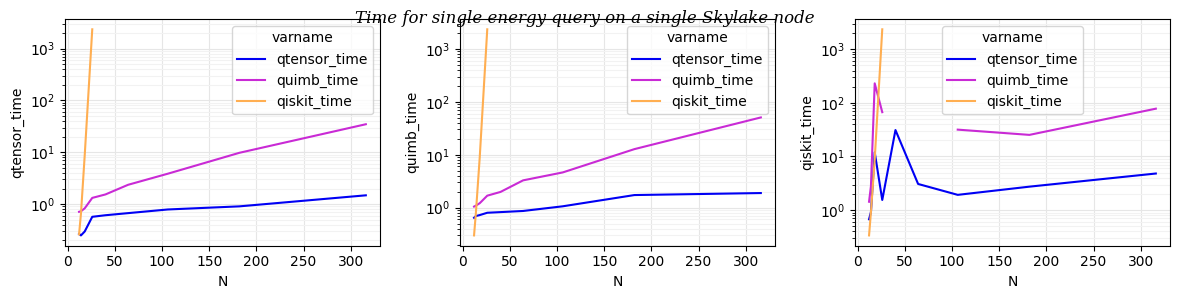

In [70]:
xar_tr = xar.transpose('p', 'varname', 'N')
#xar_tr = xar_tr.rename({'varname':'lib'})
fig = ex.plot_xarray(xar_tr)

In [21]:
#export
def plot_xar_data(xar_orig):
    xar = xar_orig.transpose('p', 'varname', 'N')
    def custom_plot(x, y, **kwargs):
        plt.plot(x, y, '*-', **kwargs)
        plt.yscale('log')
        plt.xscale('log', base=2)
    fig = ex.plot_xarray(xar, plot_func=custom_plot)

    axes = fig.axes
    axes[0].get_shared_y_axes().join(*axes)
    axes[0].get_shared_x_axes().join(*axes)
    ps = [x.data for x in xar.coords['p']]


    [ax.autoscale() for ax in axes]
    [ax.set_ylabel('Time, sec') for ax in axes]
    [ax.set_title(x) for ax, x in zip(axes, [f"p = {p}" for p in ps])]
    fig.suptitle('Time for single energy query on a single Skylake node', fontfamily='serif', style='italic')
    fig.set_size_inches(10.5, 4.5)
    fig.tight_layout(rect=[0, 0.03, 1, 0.98])


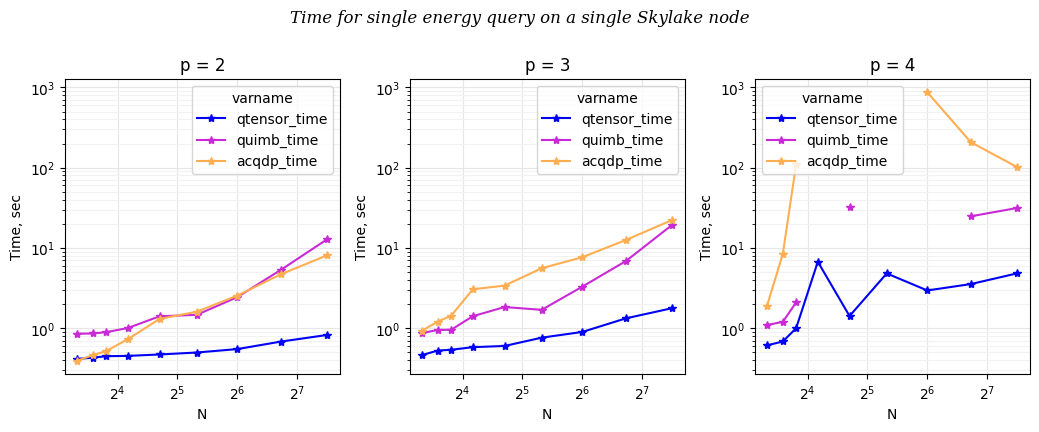

In [35]:
plot_xar_data(xar)

## CLI

In [49]:
#export
from qtensor_specs import cli, click

In [50]:
#export
@cli.command()
@click.option('--n_len', default=4)
@click.option('--p_len', default=2)
@click.option('-O', '--qtn_ordering_algo', default='greedy')
@click.option('-N', '--n_processes', default=2)
@click.argument('filename')
def time_comparison_xarray(filename, n_len, p_len, **kwargs):
    Ns = 2*(.5*np.pi**(np.arange(0, 12)/2)).astype(np.int) + 10
    Ns = Ns[:n_len]
    ps = [2, 3, 4]
    ps = ps[:p_len]
    kwargs = {k:[v] for k, v in kwargs.items()}
    xar = gen_time_data(Ns, ps, **kwargs)
    xar.to_netcdf(filename)
    

In [62]:
#export
import logging
ql = logging.getLogger('qiskit')
ql.setLevel(logging.ERROR)

In [64]:
Ns = [10, 14]
ps = [2, 3]
xar = gen_time_data(Ns, ps)



_dimcount 3


In [65]:
#hide
#default_exp speed_comparison

from nbdev.export  import *
notebook2script()

Converted QAOA_bench.ipynb.
Converted Speed_comparison.ipynb.
Converted Time_vs_FLOP.ipynb.
Converted index.ipynb.
